In [1]:
import sys

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# Please append your own directory after ‘/content/drive/My Drive/'
# where you have nutil.py and adult_subsample.csv
### ========== TODO : START ========== ###
sys.path += ['/content/drive/MyDrive/HW2/code'] 
### ========== TODO : END ========== ###

In [4]:
from nutil import *

In [5]:
# Use only the provided packages!
import math
import csv

from collections import Counter

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import learning_curve

In [6]:
######################################################################
# Immutatble classes
######################################################################

class Classifier(object) :
    """
    Classifier interface.
    """

    def fit(self, X, y):
        raise NotImplementedError()

    def predict(self, X):
        raise NotImplementedError()


class MajorityVoteClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that always predicts the majority class.

        Attributes
        --------------------
            prediction_ -- majority class
        """
        self.prediction_ = None

    def fit(self, X, y) :
        """
        Build a majority vote classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """
        majority_val = Counter(y).most_common(1)[0][0]
        self.prediction_ = majority_val
        return self

    def predict(self, X) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.prediction_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")

        n,d = X.shape
        y = [self.prediction_] * n
        return y



In [7]:
######################################################################
# Mutatble classes
######################################################################

class RandomClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that predicts according to the distribution of the classes.

        Attributes
        --------------------
            probabilities_ -- class distribution dict (key = class, val = probability of class)
        """
        self.probabilities_ = None

    def fit(self, X, y) :
        """
        Build a random classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """

        ### ========== TODO : START ========== ###
        # part b: set self.probabilities_ according to the training set

        unique_classes, class_counts = np.unique(y, return_counts=True)
        total_samples = len(y)
        probabilities = class_counts / total_samples

        # Create class distribution dictionary
        self.probabilities_ = dict(zip(unique_classes, probabilities))
        ### ========== TODO : END ========== ###

        return self

    def predict(self, X, seed=1234) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            seed -- integer, random seed

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.probabilities_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")
        np.random.seed(seed)
         ### ========== TODO : START ========== ###
        # Predict the class for each test example
        n = X.shape[0]  # number of test examples
        unique_classes = list(self.probabilities_.keys())
        probabilities = list(self.probabilities_.values())

        # Randomly assign class labels based on probabilities
        y = np.random.choice(unique_classes, size=n, p=probabilities)
    ### ========== TODO : END ========== ###  

        return y


In [8]:
######################################################################
# Immutatble functions
######################################################################

def plot_histograms(X, y, Xnames, yname) :
    n,d = X.shape  # n = number of examples, d =  number of features
    fig = plt.figure(figsize=(20,15))
    ncol = 3
    nrow = d // ncol + 1
    for i in range(d) :
        fig.add_subplot (nrow,ncol,i+1)
        data, bins, align, labels = plot_histogram(X[:,i], y, Xname=Xnames[i], yname=yname, show = False)
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xnames[i])
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')

    plt.savefig ('histograms.pdf')


def plot_histogram(X, y, Xname, yname, show = True) :
    """
    Plots histogram of values in X grouped by y.

    Parameters
    --------------------
        X     -- numpy array of shape (n,d), feature values
        y     -- numpy array of shape (n,), target classes
        Xname -- string, name of feature
        yname -- string, name of target
    """

    # set up data for plotting
    targets = sorted(set(y))
    data = []; labels = []
    for target in targets :
        features = [X[i] for i in range(len(y)) if y[i] == target]
        data.append(features)
        labels.append('%s = %s' % (yname, target))

    # set up histogram bins
    features = set(X)
    nfeatures = len(features)
    test_range = list(range(int(math.floor(min(features))), int(math.ceil(max(features)))+1))
    if nfeatures < 10 and sorted(features) == test_range:
        bins = test_range + [test_range[-1] + 1] # add last bin
        align = 'left'
    else :
        bins = 10
        align = 'mid'

    # plot
    if show == True:
        plt.figure()
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xname)
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')
        plt.show()

    return data, bins, align, labels


In [9]:
######################################################################
# Mutatble functions
######################################################################

def error(clf, X, y, ntrials=100, test_size=0.2) :
    """
    Computes the classifier error over a random split of the data,
    averaged over ntrials runs.

    Parameters
    --------------------
        clf         -- classifier
        X           -- numpy array of shape (n,d), features values
        y           -- numpy array of shape (n,), target classes
        ntrials     -- integer, number of trials

    Returns
    --------------------
        train_error -- float, training error
        val_error  -- float, validation error
        f1_score    -- float, validation "micro" averaged f1 score
    """

    ### ========== TODO : START ========== ###
    # part f:
    # compute cross-validation error using StratifiedShuffleSplit over ntrials
    # hint: use StratifiedShuffleSplit (be careful of the parameters)
    train_error_sum = 0
    val_error_sum = 0
    f1_score_sum = 0

    sss = StratifiedShuffleSplit(n_splits=ntrials, test_size=test_size, random_state=0)

    for train_index, val_index in sss.split(X, y):
      X_train, X_val = X[train_index], X[val_index]
      y_train, y_val = y[train_index], y[val_index]

      clf.fit(X_train, y_train)
      y_pred_train = clf.predict(X_train)
      y_pred_val = clf.predict(X_val)

      train_error = 1 - metrics.accuracy_score(y_train, y_pred_train, normalize=True)
      val_error = 1 - metrics.accuracy_score(y_val, y_pred_val, normalize=True)
      f1 = metrics.f1_score(y_val, y_pred_val, average='micro')

      train_error_sum += train_error
      val_error_sum += val_error
      f1_score_sum += f1

    train_error = train_error_sum / ntrials
    val_error = val_error_sum / ntrials
    f1_score = f1_score_sum / ntrials

    ### ========== TODO : END ========== ###

    return train_error, val_error, f1_score




In [10]:
######################################################################
# Immutatble functions
######################################################################


def write_predictions(y_pred, filename, yname=None) :
    """Write out predictions to csv file."""
    out = open(filename, 'wb')
    f = csv.writer(out)
    if yname :
        f.writerow([yname])
    f.writerows(list(zip(y_pred)))
    out.close()


In [11]:
######################################################################
# main
######################################################################
    
# load adult_subsample dataset with correct file path

### ========== TODO : START ========== ###
# for example data_file =  "/content/drive/My Drive/cs146/hw1/adult_subsample.csv"
data_file = "/content/drive/MyDrive/HW2/code/adult_subsample.csv"
### ========== TODO : END ========== ###

data = load_data(data_file, header=1, predict_col=-1)

X = data.X; Xnames = data.Xnames
y = data.y; yname = data.yname
n,d = X.shape  # n = number of examples, d =  number of features


Plotting...


<Figure size 640x480 with 0 Axes>

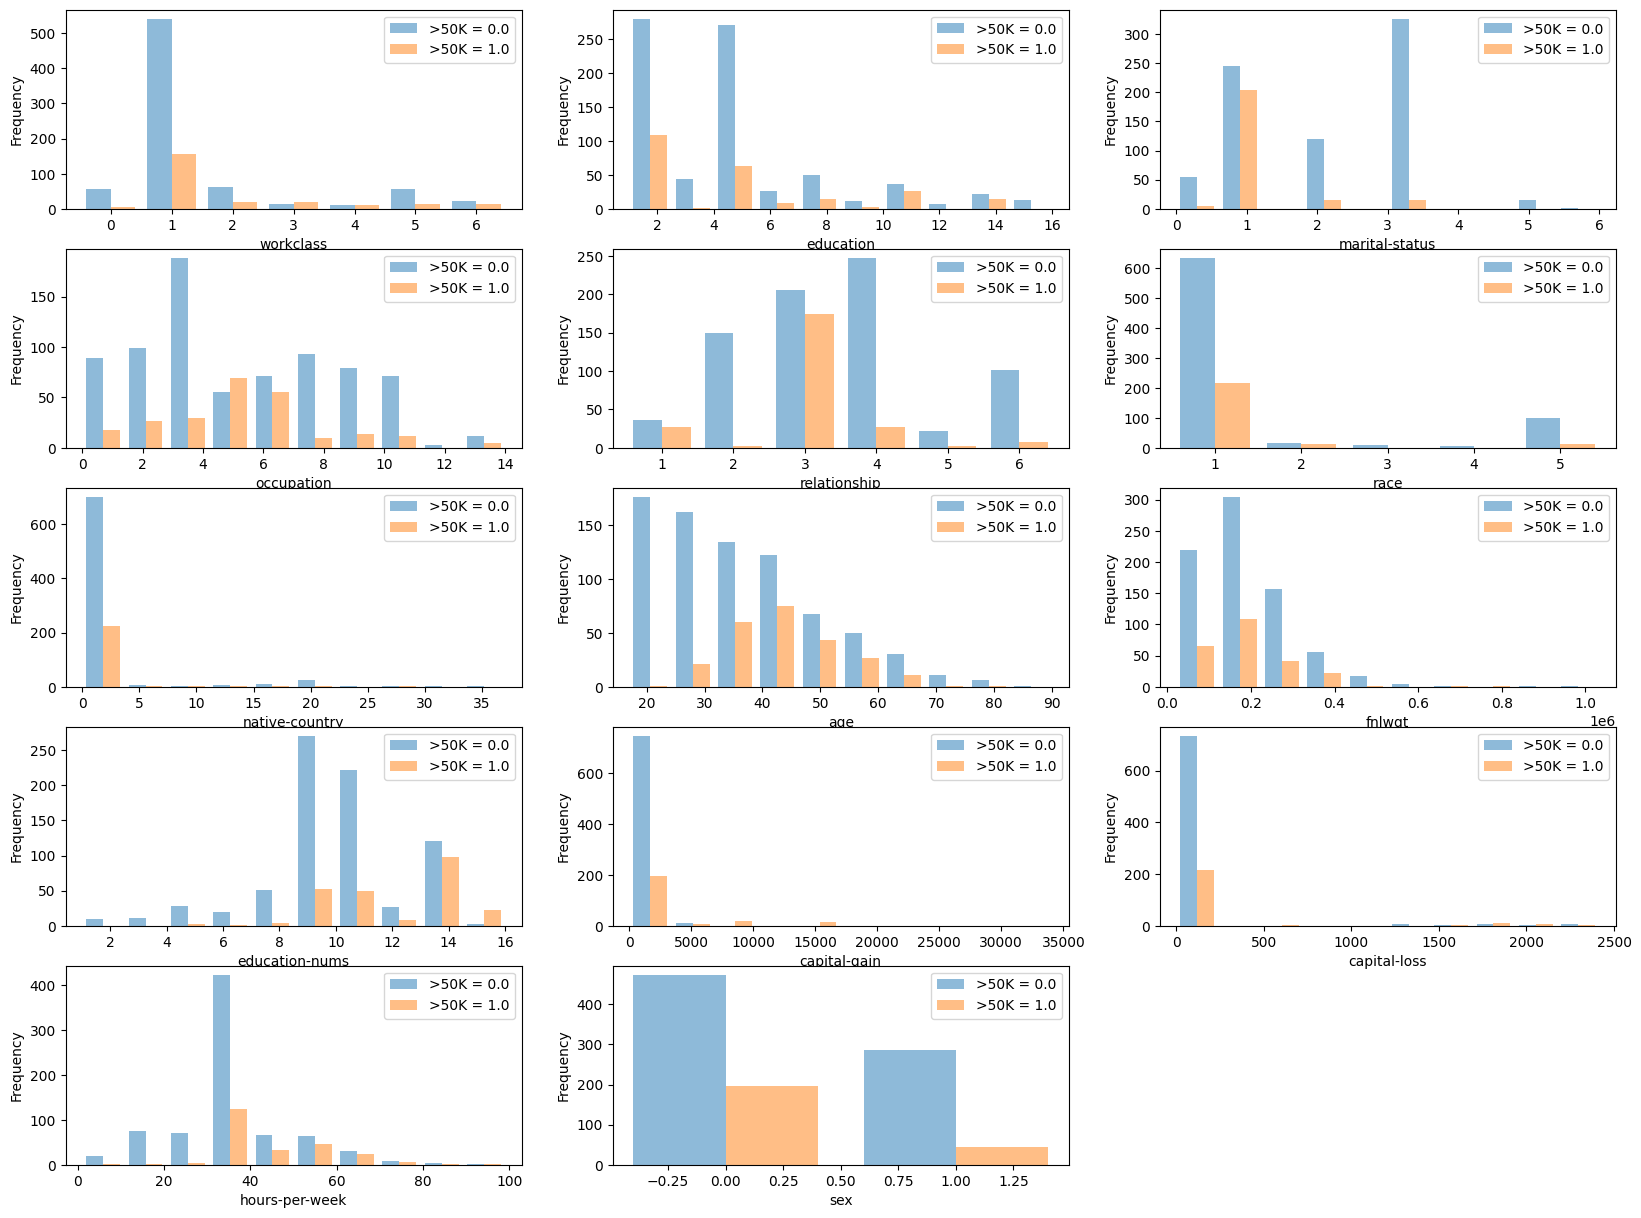

In [12]:
plt.figure()
#========================================
# part a: plot histograms of each feature
print('Plotting...')
plot_histograms (X, y, Xnames=Xnames, yname=yname)

In [13]:
#========================================
# train Majority Vote classifier on data
print('Classifying using Majority Vote...')
clf = MajorityVoteClassifier() # create MajorityVote classifier, which includes all model parameters
clf.fit(X, y)                  # fit training data using the classifier
y_pred = clf.predict(X)        # take the classifier and run it on the training data
train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
print('\t-- training error: %.3f' % train_error)

Classifying using Majority Vote...
	-- training error: 0.240


In [14]:
### ========== TODO : START ========== ###
# part b: evaluate training error of Random classifier
# train Random classifier on data
print('Classifying using Random...')
clf = RandomClassifier() # create MajorityVote classifier, which includes all model parameters
clf.fit(X, y)                  # fit training data using the classifier
y_pred = clf.predict(X)        # take the classifier and run it on the training data
train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
print('\t-- training error: %.3f' % train_error)
### ========== TODO : END ========== ###

Classifying using Random...
	-- training error: 0.374


In [15]:
### ========== TODO : START ========== ###
# part c: evaluate training error of Decision Tree classifier
print('Classifying using Decision Tree...')
clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(X, y)
y_pred = clf.predict(X)
train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
print('\t-- training error: %.3f' % train_error)
### ========== TODO : END ========== ###

Classifying using Decision Tree...
	-- training error: 0.000


In [16]:
### ========== TODO : START ========== ###
# part d: evaluate training error of k-Nearest Neighbors classifier
# use k = 3, 5, 7 for n_neighbors
print('Classifying using k-Nearest Neighbors...')
k_values = [3, 5, 7]
classifiers = []
for k in k_values:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X, y)
    classifiers.append(clf)

train_errors = []
for classifier in classifiers:
    y_pred = classifier.predict(X)
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    train_errors.append(train_error)

for i, k in enumerate(k_values):
    print(f"\t-- training error (k={k}): %.3f" % train_errors[i])
### ========== TODO : END ========== ###

Classifying using k-Nearest Neighbors...
	-- training error (k=3): 0.153
	-- training error (k=5): 0.195
	-- training error (k=7): 0.213


In [21]:
### ========== TODO : START ========== ###
# part e: evaluate training error of Logistic Regression
# use lambda_ = 0.1, 1, 10 for n_neighbors
print('Classifying using Logistic Regression...')
lambda_values = [0.1, 1, 10]
classifiers = []
for lambda_val in lambda_values:
    C_val = 1 / lambda_val
    clf = LogisticRegression(random_state=0, max_iter=1000, C=C_val)
    clf.fit(X, y)
    classifiers.append(clf)
  
train_errors = []
for classifier in classifiers:
    y_pred = classifier.predict(X)
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    train_errors.append(train_error)

# Report the training errors
for i, lambda_val in enumerate(lambda_values):
    print(f"\t-- training error (λ={lambda_val}): %.3f" % train_errors[i])


### ========== TODO : END ========== ###

Classifying using Logistic Regression...
	-- training error (λ=0.1): 0.208
	-- training error (λ=1): 0.208
	-- training error (λ=10): 0.220


In [22]:
### ========== TODO : START ========== ###
# part f: use cross-validation to compute average training and validation error of classifiers
print('Investigating various classifiers...')
random_clf = RandomClassifier()
dt_clf = DecisionTreeClassifier(criterion='entropy')
knn_clf = KNeighborsClassifier(n_neighbors=5)
lr_clf = LogisticRegression(random_state=0, max_iter=1000, C=1)

ntrials = 100
test_size = 0.15

random_train_error, random_val_error, random_f1_score = error(random_clf, X, y, ntrials=ntrials, test_size=test_size)
dt_train_error, dt_val_error, dt_f1_score = error(dt_clf, X, y, ntrials=ntrials, test_size=test_size)
knn_train_error, knn_val_error, knn_f1_score = error(knn_clf, X, y, ntrials=ntrials, test_size=test_size)
lr_train_error, lr_val_error, lr_f1_score = error(lr_clf, X, y, ntrials=ntrials, test_size=test_size)

print("Random Classifier:")
print(f"\t-- average training error: %.3f" % random_train_error)
print(f"\t-- average validation error: %.3f" % random_val_error)
print(f"\t-- average validation f1 error: %.3f" % random_f1_score + "\n")

print("Decision Tree Classifier:")
print(f"\t-- average training error: %.3f" % dt_train_error)
print(f"\t-- average validation error: %.3f" % dt_val_error)
print(f"\t-- average validation f1 error: %.3f" % dt_f1_score + "\n")

print("k-Nearest Neighbors:")
print(f"\t-- average training error: %.3f" % knn_train_error)
print(f"\t-- average validation error: %.3f" % knn_val_error)
print(f"\t-- average validation f1 error: %.3f" % knn_f1_score + "\n")

print("Logistic Regression Classifier:")
print(f"\t-- average training error: %.3f" % lr_train_error)
print(f"\t-- average validation error: %.3f" % lr_val_error)
print(f"\t-- average validation f1 error: %.3f" % lr_f1_score + "\n")
### ========== TODO : END ========== ###

Investigating various classifiers...
Random Classifier:
	-- average training error: 0.372
	-- average validation error: 0.367
	-- average validation f1 error: 0.633

Decision Tree Classifier:
	-- average training error: 0.000
	-- average validation error: 0.202
	-- average validation f1 error: 0.798

k-Nearest Neighbors:
	-- average training error: 0.200
	-- average validation error: 0.254
	-- average validation f1 error: 0.746

Logistic Regression Classifier:
	-- average training error: 0.207
	-- average validation error: 0.212
	-- average validation f1 error: 0.788



Finding the best k...


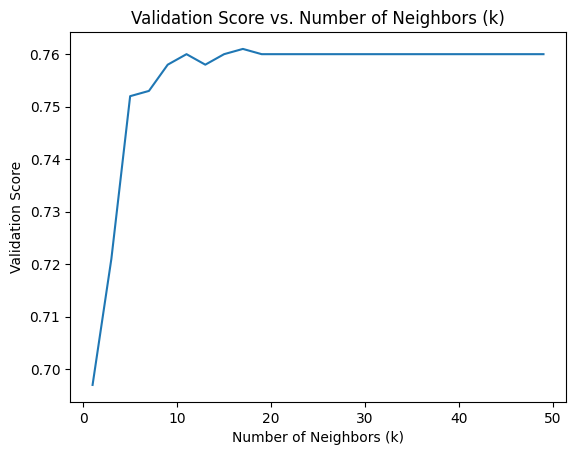

Best value of k: 17
Corresponding score: 0.761


In [23]:
### ========== TODO : START ========== ###
# part g: use 5-fold cross-validation to find the best value of k for k-Nearest Neighbors classifier
print('Finding the best k...')
k_values = list(range(1, 51, 2))
scores = []

for k in k_values:
    clf = KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(clf, X, y, cv=5)
    mean_score = np.mean(cv_scores)
    scores.append(mean_score)

plt.plot(k_values, scores)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Validation Score')
plt.title('Validation Score vs. Number of Neighbors (k)')
plt.show()

best_k = k_values[np.argmax(scores)]
best_score = np.max(scores)

print(f"Best value of k: {best_k}")
print(f"Corresponding score: %.3f" % best_score)
### ========== TODO : END ========== ###

Investigating depths...


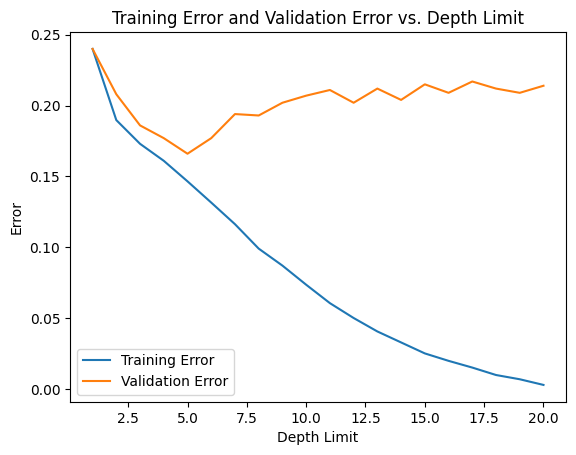

In [ ]:
### ========== TODO : START ========== ###
# part h: investigate decision tree classifier with various depths
print('Investigating depths...')
depth_limits = list(range(1, 21))
train_errors = []
val_errors = []

for depth in depth_limits:
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=depth)
    scores = cross_validate(clf, X, y, cv=5, return_train_score=True)
    train_error = 1 - np.mean(scores['train_score'])
    val_error = 1 - np.mean(scores['test_score'])
    train_errors.append(train_error)
    val_errors.append(val_error)

plt.plot(depth_limits, train_errors, label='Training Error')
plt.plot(depth_limits, val_errors, label='Validation Error')
plt.xlabel('Depth Limit')
plt.ylabel('Error')
plt.title('Training Error and Validation Error vs. Depth Limit')
plt.legend()
plt.show()
### ========== TODO : END ========== ###

In [ ]:
import numpy as np
from numpy.linalg import norm
# define two lists or array
test = np.array([[1, 5], [4, 7], [6, 2], [9, 5], [5, 5]])
train = np.array([[2, 6], [2, 7], [3, 7], [4, 8], [5, 1], [5, 4], [5, 9], [7, 2], [7, 3], [8, 3], [8, 4], [8, 8]])

def sim(test_point, train_dataset):

  best = float("-inf")
  idx = -1
  for i in range(len(train_dataset)):
    A = test_point
    B = train_dataset[i]
    simi = np.dot(A,B)/(norm(A)*norm(B))

    if simi > best:
      best = simi
      idx = i

  return best

most_similar = []
for i in range(len(test)):
  most_sim = sim(test[i], train)
  most_similar.append(most_sim)

print(most_similar)

    

[0.9967290481146759, 0.9999274284261899, 0.9993148337667671, 0.9990561583550595, 0.9999999999999998]
